# Get Data using Reddit's API

In [1]:
from dotenv import load_dotenv
from os import getenv
import requests
import json
import praw
from datetime import datetime
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
load_dotenv()

True

In [3]:
reddit = praw.Reddit(
    client_id=getenv("APP_ID"), # Right below 'personal use script'
    client_secret=getenv("APP_SECRET"), # secret
    user_agent=f"pda-2023 u/{getenv('USERNAME')}", # app-name u/username
    password=getenv('REDDIT_PASSWORD')
)
print(reddit.read_only)

True


## Storage as json

In [4]:
def comment_transport_json(subreddit,topic,post,comment):
    
    #json method

    # Selecting number of posts 
    subreddit = reddit.subreddit(subreddit)
    search = subreddit.search(topic, limit=post)
    limit=comment

    #Create dictionary    
    postDict = {}

    #Select post & comments
    for submission in search:
        postDict[submission.title] = []
        for comment in submission.comments.list()[:limit]:
            postDict[submission.title].append({
                'Comment':comment.body,
                'Date': str(datetime.utcfromtimestamp(comment.created_utc))
            })

    #Convert data in json format
    data=json.dumps(postDict)

    #Save data in a json file
    with open(f"{subreddit}_{topic}_Comments.json",'w') as f:
        f.write(data)
    
    print(f"\n {subreddit}_{topic}_comments.json file created! \n")

In [5]:
comment_transport_json('Monterrey','transmetro',20,10)


 Monterrey_transmetro_comments.json file created! 



## Storage as csv 

In [6]:
def comments_transport_csv(subreddit,topic,post,comments):
    # Selecting number of posts for Transmetro
    subreddit = reddit.subreddit(subreddit)
    search = subreddit.search(topic, limit=post)

    #Create an empty df 
    df_comm=pd.DataFrame(columns=["Post", "Comment", "Date"])

    # Getting comments for every post
    for submission in search:

        for comment in submission.comments.list()[:comments]:
            df_comm = df_comm.append({"Post":submission.title,"Comment": comment.body,"Date":datetime.utcfromtimestamp(comment.created_utc)}, ignore_index=True)

    df_comm['Sentiment_Value'] = df_comm['Comment'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df_comm['Sentiment'] = df_comm['Sentiment_Value'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
    
    df_comm.to_csv(f"{subreddit}_{topic}_comments.csv",index=False)
    print(f"\n {subreddit}_{topic}_comments.csv file created! \n")
    return df_comm.head(10)


In [36]:
comments_transport_csv('ireland','LUAS',10,15)


 ireland_LUAS_comments.csv file created! 



,Post,Comment,Date,Sentiment_Value,Sentiment
0,I worked as Luas Security for 4 Years AMA,Can you think of any reason why this type of s...,2023-05-14 09:32:17,0.000000,Neutral
1,I worked as Luas Security for 4 Years AMA,How many times were you attacked ?,2023-05-14 09:36:49,0.500000,Positive
2,I worked as Luas Security for 4 Years AMA,How often were you in court as a result of you...,2023-05-14 09:29:34,0.000000,Neutral
3,I worked as Luas Security for 4 Years AMA,"How much, if any, help you would like or need...",2023-05-14 10:04:21,0.200000,Positive
4,I worked as Luas Security for 4 Years AMA,What was the worst thing you've seen?,2023-05-14 09:46:10,-1.000000,Negative
5,I worked as Luas Security for 4 Years AMA,What's the nicest thing you ever seen happen o...,2023-05-14 10:45:38,0.000000,Neutral
6,I worked as Luas Security for 4 Years AMA,How do the two lines compare? Obviously the pu...,2023-05-14 12:05:26,-0.138889,Negative
7,I worked as Luas Security for 4 Years AMA,What made you leave the job? Was the salary an...,2023-05-14 10:15:41,0.700000,Positive
8,I worked as Luas Security for 4 Years AMA,Are u a big Polish tank of a fella?,2023-05-14 17:37:30,0.000000,Neutral
9,I worked as Luas Security for 4 Years AMA,How often did you just not bother getting invo...,2023-05-14 10:09:27,0.033333,Positive


In [7]:
comments_transport_csv('Monterrey','transmetro',10,15)


 Monterrey_transmetro_comments.csv file created! 



,Post,Comment,Date,Sentiment_Value,Sentiment
0,Transmetro: Sendero,De que ruta hablas,2023-12-15 11:48:17,0.000000,Neutral
1,Transmetro: Sendero,tengo entendido los verdes son con la tarjeta ...,2023-12-15 20:57:26,0.000000,Neutral
2,Esto acaba de pasar en el transmetro de No ree...,Pinche gente enferma...\n\nAfortunadamente est...,2021-10-18 13:38:33,0.000000,Neutral
3,Esto acaba de pasar en el transmetro de No ree...,Srta. recuerdo un trucazo que vi en un anime p...,2021-10-18 14:35:23,0.000000,Neutral
4,Esto acaba de pasar en el transmetro de No ree...,Una vez me platicó mi mamá que cuando tenía qu...,2021-10-18 15:31:33,0.000000,Neutral
5,Esto acaba de pasar en el transmetro de No ree...,"Que mal pedo, en la próxima (espero no te vuel...",2021-10-18 15:30:07,0.000000,Neutral
6,Esto acaba de pasar en el transmetro de No ree...,Yo una vez salía a mi trabajo y mientras camin...,2021-10-18 15:34:27,0.214286,Positive
7,Esto acaba de pasar en el transmetro de No ree...,"una amiga compró un Taser, para esas cosas, lo...",2021-10-18 18:01:34,0.000000,Neutral
8,Esto acaba de pasar en el transmetro de No ree...,Lamento mucho que te haya pasado algo así.. Lo...,2021-10-18 15:59:10,0.025000,Positive
9,Esto acaba de pasar en el transmetro de No ree...,[removed],2021-10-18 15:45:52,0.000000,Neutral


# Sentiment Analysis

For the sentimen analysis we can use either the json & csv files created in the last steps or we can get them dirrectly from the Reddit API 

In [8]:
#!pip install nltk
#!pip install textblob

### Sentiement distribution

In [9]:
### Create a function to generate sentiment analysis

def sentiment_analysis(subreddit,topic,posts,comments):
    # Selecting number of posts 
    subreddit = reddit.subreddit(subreddit)
    search = subreddit.search(topic, limit=posts)

    #Create an empty df 
    df_comm=pd.DataFrame(columns=["Post", "Comment", "Date"])

    # Getting comments for every post
    for submission in search:

        for comment in submission.comments.list()[:comments]:
            df_comm = df_comm.append({"Post":submission.title,"Comment": comment.body,"Date":datetime.utcfromtimestamp(comment.created_utc)}, ignore_index=True)

    #Sentiment Analysis
    df_comm['Sentiment_Value'] = df_comm['Comment'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df_comm['Sentiment'] = df_comm['Sentiment_Value'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
    
    #Calculate an average of the seniment
    avg_sentiment = df_comm['Sentiment'].value_counts(normalize=True).idxmax()

    # Plotting a pie chart
    sentiment_distribution = df_comm['Sentiment'].value_counts(normalize=True) * 100
    labels = sentiment_distribution.index
    sizes = sentiment_distribution.values
    explode = (0.1, 0, 0)  # explode 1st slice

    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f"Sentiment Distribution of {topic} in {subreddit}")
    plt.show()

      
    return (f"According to this analysis people have a {avg_sentiment} image of {topic}")

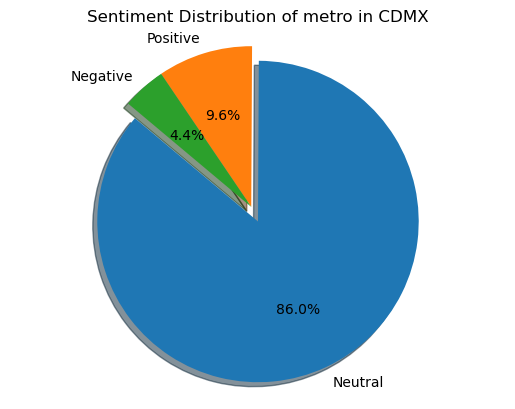

'According to this analysis people have a Neutral image of metro'

In [10]:
sentiment_analysis('CDMX','metro',15,10)

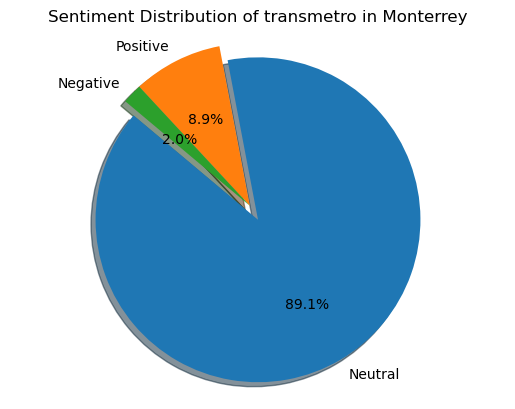

'According to this analysis people have a Neutral image of transmetro'

In [11]:
sentiment_analysis('Monterrey','transmetro',50,10)

### Sentiment prediction

In [12]:
#Read dataset
df_sa=pd.read_csv('Monterrey_transmetro_comments.csv') #we can use a dataset created in the last steps
df_sa

,Post,Comment,Date,Sentiment_Value,Sentiment
0,Transmetro: Sendero,De que ruta hablas,2023-12-15 11:48:17,0.0,Neutral
1,Transmetro: Sendero,tengo entendido los verdes son con la tarjeta ...,2023-12-15 20:57:26,0.0,Neutral
2,Esto acaba de pasar en el transmetro de No ree...,Pinche gente enferma...\n\nAfortunadamente est...,2021-10-18 13:38:33,0.0,Neutral
3,Esto acaba de pasar en el transmetro de No ree...,Srta. recuerdo un trucazo que vi en un anime p...,2021-10-18 14:35:23,0.0,Neutral
4,Esto acaba de pasar en el transmetro de No ree...,Una vez me platicó mi mamá que cuando tenía qu...,2021-10-18 15:31:33,0.0,Neutral
...,...,...,...,...,...
75,¿Qué pasó con el Transmetro Las Puentes en est...,¿O sea todo sigue igual solo que ahora es verd...,2023-08-06 04:08:16,0.0,Neutral
76,¿Qué pasó con el Transmetro Las Puentes en est...,Esto es lo que buscaba. Muchas gracias.,2023-08-07 01:59:00,0.0,Neutral
77,¿Qué pasó con el Transmetro Las Puentes en est...,👍,2023-08-07 02:45:18,0.0,Neutral
78,¿Qué pasó con el Transmetro Las Puentes en est...,"Una pregunta más, ojalá pudieras ayudarme. La ...",2023-08-07 20:36:51,0.0,Neutral


From this dataset we only need the columns [Commens] and [Sentiment]

In [13]:
#Select columns to analyze
data=df_sa.loc[:,['Comment','Sentiment']]
data

,Comment,Sentiment
0,De que ruta hablas,Neutral
1,tengo entendido los verdes son con la tarjeta ...,Neutral
2,Pinche gente enferma...\n\nAfortunadamente est...,Neutral
3,Srta. recuerdo un trucazo que vi en un anime p...,Neutral
4,Una vez me platicó mi mamá que cuando tenía qu...,Neutral
...,...,...
75,¿O sea todo sigue igual solo que ahora es verd...,Neutral
76,Esto es lo que buscaba. Muchas gracias.,Neutral
77,👍,Neutral
78,"Una pregunta más, ojalá pudieras ayudarme. La ...",Neutral


In [14]:
#Create Sentiment Analyzer object
sent_analyzer = SentimentIntensityAnalyzer()

In [15]:
#Create function to predict sentiment analysis

def format_output(output_dict):
  
  polarity = "Neutral"

  if(output_dict['compound'] >= 0.05):
    polarity = "Positive"

  elif(output_dict['compound'] <= -0.05):
    polarity = "Negative"

  return polarity

def predict_sentiment(text):
  
  output_dict =  sent_analyzer.polarity_scores(text)
  return format_output(output_dict)

In [16]:
#Apply sentiment prediction to a column and storage it in a new column

data["vader_prediction"] = data["Comment"].apply(predict_sentiment)

In [17]:
data.head(10)

,Comment,Sentiment,vader_prediction
0,De que ruta hablas,Neutral,Neutral
1,tengo entendido los verdes son con la tarjeta ...,Neutral,Neutral
2,Pinche gente enferma...\n\nAfortunadamente est...,Neutral,Neutral
3,Srta. recuerdo un trucazo que vi en un anime p...,Neutral,Neutral
4,Una vez me platicó mi mamá que cuando tenía qu...,Neutral,Neutral
5,"Que mal pedo, en la próxima (espero no te vuel...",Neutral,Negative
6,Yo una vez salía a mi trabajo y mientras camin...,Positive,Positive
7,"una amiga compró un Taser, para esas cosas, lo...",Neutral,Negative
8,Lamento mucho que te haya pasado algo así.. Lo...,Positive,Neutral
9,[removed],Neutral,Neutral


In [18]:
#Compute accuracy of the prediction compared to the actual values

from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(data['Sentiment'], data['vader_prediction'])

print("Accuracy: {}\n".format(accuracy))

# Show the classification report
print(classification_report(data['Sentiment'], data['vader_prediction']))

Accuracy: 0.625

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         1
     Neutral       0.96      0.65      0.77        74
    Positive       0.67      0.40      0.50         5

    accuracy                           0.62        80
   macro avg       0.54      0.35      0.42        80
weighted avg       0.93      0.62      0.75        80



In [39]:
#Read dataset
df_sa=pd.read_csv('ireland_LUAS_comments.csv') #we can use a dataset created in the last steps

#Select columns to analyze
data=df_sa.loc[:,['Comment','Sentiment']]

#Create Sentiment Analyzer object
sent_analyzer = SentimentIntensityAnalyzer()

#Create function to predict sentiment analysis

def format_output(output_dict):
  
  polarity = "Neutral"

  if(output_dict['compound'] >= 0.05):
    polarity = "Positive"

  elif(output_dict['compound'] <= -0.05):
    polarity = "Negative"

  return polarity

def predict_sentiment(text):
  
  output_dict =  sent_analyzer.polarity_scores(text)
  return format_output(output_dict)

#Apply sentiment prediction to a column and storage it in a new column

data["vader_prediction"] = data["Comment"].apply(predict_sentiment)

#Compute accuracy of the prediction compared to the actual values

from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(data['Sentiment'], data['vader_prediction'])

print("Accuracy: {}\n".format(accuracy))

# Show the classification report
print(classification_report(data['Sentiment'], data['vader_prediction']))

Accuracy: 0.625

              precision    recall  f1-score   support

    Negative       0.49      0.73      0.59        33
     Neutral       0.76      0.56      0.64        52
    Positive       0.65      0.63      0.64        51

    accuracy                           0.62       136
   macro avg       0.64      0.64      0.62       136
weighted avg       0.66      0.62      0.63       136



## Bag of words

In [38]:
#Loading the Dataset
df_bw = pd.read_csv('Monterrey_transmetro_comments.csv')

# Pre-Prcoessing and Bag of Word Vectorization using Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

#Creating languages for the stopwords
stop_words_sp = set(stopwords.words('spanish'))
stop_words_en = set(stopwords.words('english'))

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
sw_sp_list = list(stop_words_sp)
cv    = CountVectorizer(stop_words = sw_sp_list,ngram_range = (1, 1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df_bw['Comment'])

#print(text_counts)

#Splitting the data into trainig and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, df_bw['Sentiment'], test_size=0.25, random_state=5)

# Training the model
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

# Caluclating the accuracy score of the model
from sklearn import metrics
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)

print(f"Accuracy Score Transmetro: ",accuracy_score)

# Now calculate accuracy for LUAS

#Loading the Dataset
df_bw_LUAS = pd.read_csv('ireland_LUAS_comments.csv')

# Pre-Prcoessing and Bag of Word Vectorization using Count Vectorizer
from sklearn.feature_extraction.text import CountVectorizer
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

#Creating languages for the stopwords
stop_words_sp = set(stopwords.words('spanish'))
stop_words_en = set(stopwords.words('english'))

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
sw_sp_list = list(stop_words_sp)
cv    = CountVectorizer(stop_words = 'english',ngram_range = (1, 1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df_bw_LUAS['Comment'])

#print(text_counts)

#Splitting the data into trainig and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, df_bw_LUAS['Sentiment'], test_size=0.25, random_state=5)

# Training the model
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

# Caluclating the accuracy score of the model
from sklearn import metrics
predicted = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predicted, Y_test)

print(f"Accuracy Score LUAS: ",accuracy_score)


Accuracy Score Transmetro:  0.8
Accuracy Score LUAS:  0.5294117647058824
